# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Подготовка данных

## Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.dummy import DummyClassifier

from sklearn.utils import shuffle

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve

In [2]:
# import kaggle
# !kaggle datasets download -d barelydedicated/bank-customer-churn-modeling

In [3]:
# Ограничим число знаков после запятой для вывода табличных данных.
pd.options.display.float_format = '{:0.3f}'.format

# Параметры отображения Seaborn.
sns.set_palette('muted')
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 2})

# Ограничим число знаков после запятой для вывода табличных данных.
pd.options.display.float_format = '{:0.3f}'.format

Загрузим и посмотрим данные.

In [4]:
url = 'https://code.s3.yandex.net/datasets/'

In [5]:
# RowNumber - индекс из .csv файла, удалим его.
try:
    df = pd.read_csv(url + 'Churn.csv', index_col='RowNumber').reset_index(drop=True)
except:
    print('Не удалось загрузить файл, проверьте путь.')

In [6]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2.000,0.000,1,1,1,101348.880,1
1,15647311,Hill,608,Spain,Female,41,1.000,83807.860,1,0,1,112542.580,0
2,15619304,Onio,502,France,Female,42,8.000,159660.800,3,1,0,113931.570,1
3,15701354,Boni,699,France,Female,39,1.000,0.000,2,0,0,93826.630,0
4,15737888,Mitchell,850,Spain,Female,43,2.000,125510.820,1,1,1,79084.100,0


Признаки CustomerId и Surname не пригодятся в дальнейшем исследовании, удаляем их.

In [7]:
df.drop(columns=['CustomerId','Surname'], inplace=True)

## Устранение пропусков в данных

Пропуски есть в столбце Tenure (сколько лет человек является клиентом банка).

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Поменяем типы.

In [9]:
df.HasCrCard = df.HasCrCard.astype(bool)
df.IsActiveMember = df.IsActiveMember.astype(bool)
df.Exited = df.Exited.astype(bool)

Целевой признак представлен одинаково в подвыборках содержащих NaN в признаке Tenure или нет.

In [10]:
df[~df.Tenure.isna()].Exited.value_counts(normalize=True)

False   0.796
True    0.204
Name: Exited, dtype: float64

In [11]:
df[df.Tenure.isna()].Exited.value_counts(normalize=True)

False   0.799
True    0.201
Name: Exited, dtype: float64

Выделим количественные признаки.

In [12]:
quantitative = df.describe(include=np.number).columns
quantitative

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary'],
      dtype='object')

Оценим наличие линейной зависимости между Tenure и другими количественными признаками.

Как видим, она близка к нулю.

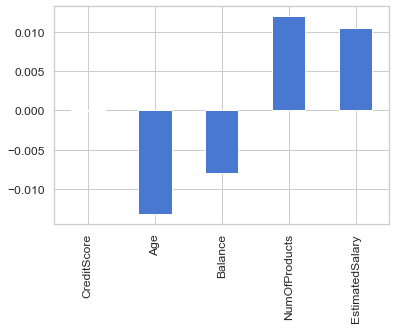

In [13]:
corr = df[quantitative].corr()['Tenure']
corr[corr.index.drop('Tenure')].plot(kind='bar');

Построим матрицу рассеяния. Признаки имею очень слабую линейную взаимосвязь между собой.

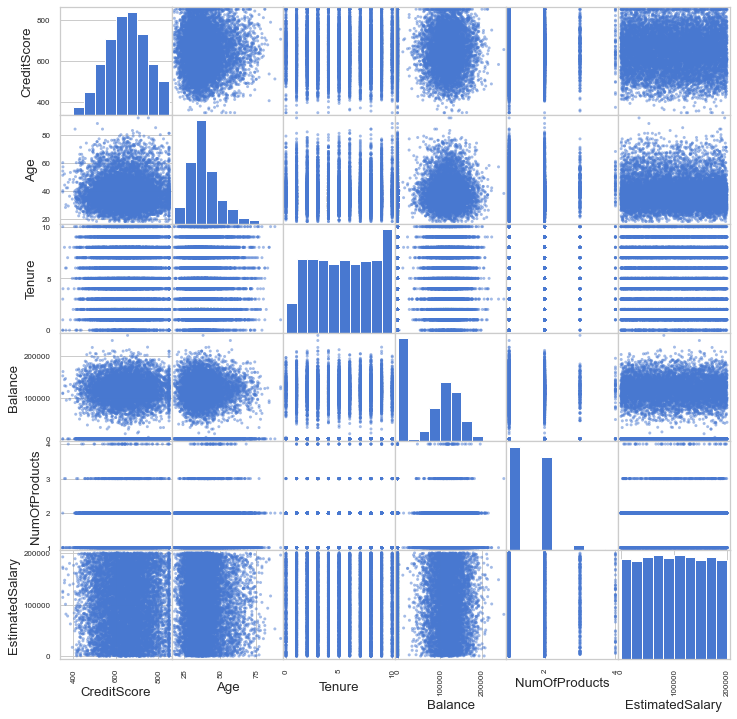

In [14]:
pd.plotting.scatter_matrix(df[corr.index], figsize=(12,12));

Построим boxplot'ы. Больше всего выбросов в Age, видно разделение по Exited.

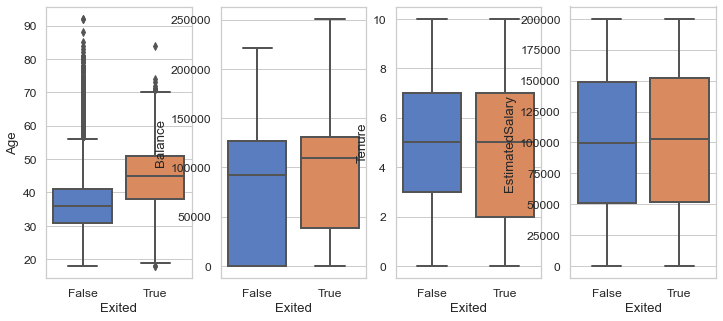

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(12,5))
sns.boxplot(data=df, y='Age', x='Exited', ax=axes[0])
sns.boxplot(data=df, y='Balance', x='Exited', ax=axes[1])
sns.boxplot(data=df, y='Tenure', x='Exited', ax=axes[2])
sns.boxplot(data=df, y='EstimatedSalary', x='Exited', ax=axes[3])
plt.show()

Запомним места, в которых встречаются пропуски (Tenure), создав новый признак, и заполним пропуски случайными значениями от 2 до 9 (т.к. данные распределены равномерно).

In [16]:
df['is_nan'] = df.Tenure.isna()
# Инициализация генератора случайных чисел
random.seed(38)
df.Tenure.fillna(random.randint(2,9), inplace=True)

## Исследование задачи

Целевой признак (факт ухода клиента) встречается относительно редко, около 20% данных имеют Exited = True.

In [17]:
df.describe(include='all')

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,is_nan
count,10000.000,10000,10000,10000.000,10000.000,10000.000,10000.000,10000,10000,10000.000,10000,10000
unique,NaN,3,2,NaN,NaN,NaN,NaN,2,2,NaN,2,2
top,NaN,France,Male,NaN,NaN,NaN,NaN,True,True,NaN,False,False
freq,NaN,5014,5457,NaN,NaN,NaN,NaN,7055,5151,NaN,7963,9091
mean,650.529,NaN,NaN,38.922,5.271,76485.889,1.530,NaN,NaN,100090.240,NaN,NaN
std,96.653,NaN,NaN,10.488,2.892,62397.405,0.582,NaN,NaN,57510.493,NaN,NaN
min,350.000,NaN,NaN,18.000,0.000,0.000,1.000,NaN,NaN,11.580,NaN,NaN
25%,584.000,NaN,NaN,32.000,3.000,0.000,1.000,NaN,NaN,51002.110,NaN,NaN
50%,652.000,NaN,NaN,37.000,5.000,97198.540,1.000,NaN,NaN,100193.915,NaN,NaN
75%,718.000,NaN,NaN,44.000,8.000,127644.240,2.000,NaN,NaN,149388.247,NaN,NaN


### Попробуем обучить модель без учёта дисбаланса и посмотреть какие метрики она выдает

Категориальные признаки Geography и Gender обработаем при помощи OHE.

In [18]:
target = df['Exited']
features = df.drop(columns='Exited')
features = pd.get_dummies(features, drop_first=True)

# Разобьём данные на тренировочную и тестовую выборки.
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=38
)

print(X_train.shape, y_train.shape)

(8000, 12) (8000,)


In [19]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,is_nan,Geography_Germany,Geography_Spain,Gender_Male
2496,567,45,8.000,0.000,2,False,True,121053.190,True,0,0,0
8995,573,28,8.000,0.000,2,False,False,77660.030,False,0,1,1
2614,546,58,3.000,106458.310,4,True,False,128881.870,False,1,0,0
1905,535,20,9.000,134874.400,1,True,True,118825.560,False,1,0,1
7528,578,46,5.000,113226.470,1,True,False,56770.760,False,0,0,1


Построим таблицу сравнения классификаторов.

In [20]:
def model_comparison(models, X_train, y_train):
    dict_ = {}
    
    for model in models:
        pipe = make_pipeline(RobustScaler(), model) 
        y_hat = pipe.fit(X_train, y_train).predict(X_test)

        dict_[f'{model}'.split('(')[0]] = {
            'Качество': accuracy_score(y_test,y_hat),
            'Точность': precision_score(y_test,y_hat),
            'Полнота' : recall_score(y_test,y_hat),
            'F1-мера' : f1_score(y_test,y_hat),
            'AUC-ROC' : roc_auc_score(y_test, y_hat)
        }

    display(pd.DataFrame.from_dict(dict_, orient='index'))

In [21]:
model_comparison([
    RandomForestClassifier(random_state=38),
    ExtraTreesClassifier(random_state=38),
    GradientBoostingClassifier(random_state=38),
    DummyClassifier(random_state=38, strategy='stratified')
], X_train, y_train)

,Качество,Точность,Полнота,F1-мера,AUC-ROC
RandomForestClassifier,0.856,0.746,0.456,0.566,0.708
ExtraTreesClassifier,0.848,0.716,0.434,0.541,0.695
GradientBoostingClassifier,0.858,0.745,0.468,0.575,0.713
DummyClassifier,0.675,0.202,0.194,0.198,0.497


>Для DummyClassifier выбрана стратегия stratified, так как иначе появляется предупреждение zero_division и Точность приравнивается 0.

## Выводы

* Без учета дисбаланса модели показывают низкую полноту <0.5, а значит имеют большое количество ложноотрицательных предсказаний.
* Все модели превзошли DummyClassifier, пройдя тест на адекватность. Так AUC-ROC для моделей расположен в районе 0.7, в то время как для DummyClassifier - 0.5

# Борьба с дисбалансом

### Метод class_weight

Воспользуемся встроенным параметром class_weight. Как видим, позитивного эффекта он не оказал.

In [22]:
model_comparison([
    RandomForestClassifier(random_state=38, class_weight='balanced_subsample'),
    ExtraTreesClassifier(random_state=38, class_weight='balanced_subsample')
], X_train, y_train)

,Качество,Точность,Полнота,F1-мера,AUC-ROC
RandomForestClassifier,0.857,0.774,0.432,0.555,0.700
ExtraTreesClassifier,0.845,0.709,0.420,0.527,0.688


### Метод upsampling

Функция для разделения признаков и целевой переменной по классам 0 и 1.

In [23]:
def delimiter(features, target):
    features_0, features_1 = features[~target], features[target]
    target_0, target_1 = target[~target], y_train[target]
    return features_0, features_1, target_0, target_1

Функция для upsampling, которая увеличивает данные, содержащие класс 1 в k раз.

In [24]:
def upsampling(features, target, k):
    features_0, features_1, target_0, target_1 = delimiter(features, target)
    return shuffle(pd.concat([features_0] + [features_1] * k),
                   pd.concat([target_0] + [target_1] * k), random_state=38)

Проведем новый расчет. Из него видно, что результаты стали лучше во многом за счет снижение точности моделей.

In [25]:
# В качестве параметров model_comparison передаем результат функции upsampling.
# k равное 7 выдает наиболее приемлемый результат, при этом GradientBoosting становится тем хуже по качеству и точности чем выше k.
model_comparison([
    RandomForestClassifier(random_state=38),
    ExtraTreesClassifier(random_state=38),
    GradientBoostingClassifier(random_state=38),
], *upsampling(X_train, y_train, 7))

,Качество,Точность,Полнота,F1-мера,AUC-ROC
RandomForestClassifier,0.840,0.629,0.544,0.583,0.730
ExtraTreesClassifier,0.848,0.713,0.434,0.540,0.695
GradientBoostingClassifier,0.712,0.405,0.847,0.548,0.762


### Метод downsampling

Функция для downsampling, которая уменьшает данные, содержащие класс 0 при помощи семплирования.

In [26]:
def downsampling(features, target, frac):
    features_0, features_1, target_0, target_1 = delimiter(features, target)
    features_downsampled = pd.concat([features_0.sample(frac=frac, random_state=38)] + [features_1])
    target_downsampled = pd.concat([target_0.sample(frac=frac, random_state=38)] + [target_1])
    
    return shuffle(features_downsampled, target_downsampled, random_state=38)

Downsampling лучше себя показывает для классификаторов GradientBoosting и ExtraTrees.

При fraction близким к 0.1 полнота стремится к 0.9-1, но сильно уменьшается качество и точность, поэтому fraction задан равный 0.45

In [27]:
model_comparison([
    RandomForestClassifier(random_state=38),
    ExtraTreesClassifier(random_state=38),
    GradientBoostingClassifier(random_state=38),
], *downsampling(X_train, y_train, 0.45))

,Качество,Точность,Полнота,F1-мера,AUC-ROC
RandomForestClassifier,0.832,0.587,0.612,0.599,0.750
ExtraTreesClassifier,0.830,0.581,0.624,0.602,0.754
GradientBoostingClassifier,0.836,0.600,0.612,0.606,0.753


## Выводы

* Наиболее гибким и эффективным методом оказался downsampling.
* Метод upsampling позволяет сохранить высокое качество и хорошо работает только для RandomForest.
* Использование метода с параметром class_weight не дало положительных результатов.

# Тестирование модели

Используем ExtraTreesClassifier, так как он показал себя стабильнее всего.

In [28]:
et_cla = ExtraTreesClassifier(random_state = 38)

In [29]:
# Сетка гиперпараметров по которым настраивается модель.
param_grid = {
    "et_cla__min_samples_split": [2 + x*2 for x in range(15)],
    "et_cla__max_depth": [2 + x*2 for x in range(15)]
}

# Формируем пайплайн в котором применяем регуляризацию RobustScaler.
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('et_cla', et_cla)
])

Получим оптимальные гиперпараметры для модели через RandomizedSearchCV. В качестве метрики кросс-валидации используем f1.

In [30]:
search = RandomizedSearchCV(pipe, param_grid, cv=5, scoring="f1",
                            n_jobs=-1, random_state = 38)
# Применем метод downsampling.
search.fit(*downsampling(X_train, y_train, 0.45))

# Выведем результаты.
model_comparison([
    search.best_estimator_
], *downsampling(X_train, y_train, 0.45))

,Качество,Точность,Полнота,F1-мера,AUC-ROC
Pipeline,0.843,0.618,0.621,0.620,0.761


Добавим найденные гиперпараметры в наш классификатор чтобы провести оптимизацию по n_estimators.

In [31]:
et_cla.set_params(min_samples_split = search.best_params_['et_cla__min_samples_split'],
                 max_depth = search.best_params_['et_cla__max_depth'])

ExtraTreesClassifier(max_depth=26, min_samples_split=10, random_state=38)

In [32]:
# Новая сетка гиперпараметров по которым настраивается модель.
param_grid = {
    "et_cla__n_estimators": [100 + x*2 for x in range(100)]
}

In [33]:
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('et_cla', et_cla)
])

Попытаемся ещё немного улучшить метрику f1, снова запустив RandomizedSearchCV.

In [34]:
search = RandomizedSearchCV(pipe, param_grid, cv=5, scoring="f1",
                            n_jobs=-1, random_state = 38)

search.fit(*downsampling(X_train, y_train, 0.45))

# Выведем результаты.
model_comparison([
    search.best_estimator_
], *downsampling(X_train, y_train, 0.45))

,Качество,Точность,Полнота,F1-мера,AUC-ROC
Pipeline,0.844,0.619,0.624,0.622,0.762


Значения гиперпараметров найденных в результате кросс-валидации.

In [35]:
search.best_params_

{'et_cla__n_estimators': 134}

## Построение ROC-кривой

Вероятность что Exited = True.

In [36]:
probabilities = search.best_estimator_ \
                        .fit(*downsampling(X_train, y_train, 0.45)) \
                        .predict_proba(X_test)[:,1]
probabilities[:5]

array([0.77439588, 0.81634388, 0.33047264, 0.07178098, 0.15906183])

Получим необходимые для построения ROC-кривой параметры.

In [37]:
fpr, tpr, _ = roc_curve(y_test, probabilities)

Выведем Receiver operating characteristic.

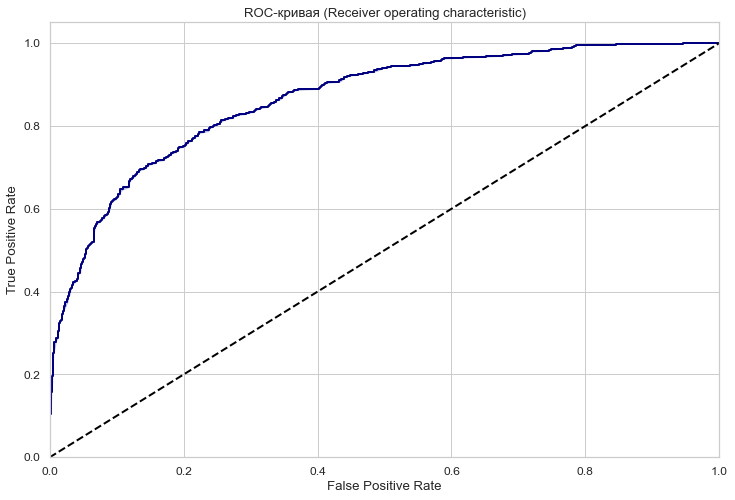

In [38]:
plt.figure(figsize=(12,8))
sns.lineplot(y=tpr, x=fpr, color='navy', drawstyle='steps-pre')
plt.plot([0, 1], [0, 1], color="black", linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая (Receiver operating characteristic)")

plt.show()

# Выводы:

* Получена модель для прогнозирования уйдёт клиент из банка в ближайшее время или нет.
* Построена модель с F1-меры равной 0.622 на тестовой выборке.
* Измерена AUC-ROC и построена ROC-кривая. На примере градиентного бустинга заметно, что при невысокой F1-мере 0.548 AUC-ROC получилась лучшей в сравнении с другими моделями 0.762.

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*